In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential , Model , load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , Input , Activation
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from keras.applications.vgg16 import VGG16 , preprocess_input
from keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as k

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os
import glob

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(os.listdir("../input/chest-xray-pneumonia/chest_xray"))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [3]:
data_dir = Path('../input/chest-xray-pneumonia/chest_xray')
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

In [4]:
def load_train():
    normal_cases_dir = train_dir / 'NORMAL'
    pneumonia_cases_dir = train_dir / 'PNEUMONIA'
    # get the list of all images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    
    train_data = []
    train_label = []
    
    for img in normal_cases:
        train_data.append(img)
        train_label.append('NORMAL')
    for img in pneumonia_cases:
        train_data.append(img)
        train_label.append('PNEUMONIA')
    
    df = pd.DataFrame(train_data)
    df.columns = ['images']
    df['labels'] = train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [5]:
train_data = load_train()
train_data.shape

(5216, 2)

In [6]:
target_labels = np.array(train_data['labels'])
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(target_labels), y= target_labels)
print(class_weights)

[1.9448173  0.67303226]


In [7]:
{v: k for v, k in enumerate(class_weights)}

{0: 1.9448173005219984, 1: 0.6730322580645162}

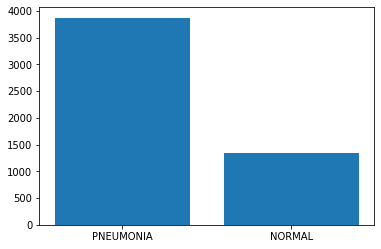

In [8]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show()

In [9]:
def plot(image_batch , label_batch):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(image_batch[i]))
        img = cv2.resize(img , (224,224))
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis('off')

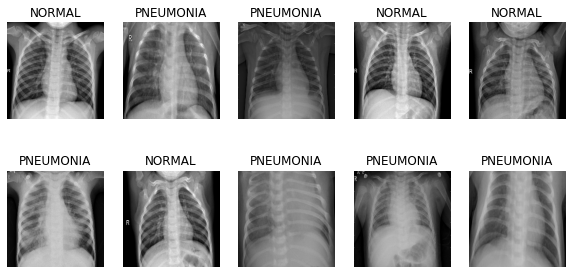

In [10]:
plot(train_data['images'] , train_data['labels'])

In [11]:
def prepare(case , normal_cases=False):
    data , labels = ([] for x in range(2))
    for img in case:
        img = cv2.imread(str(img))
        img = cv2.resize(img , (224,224))
        if img.shape[2] == 1:
            img = np.dstack([img,img,img])
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255
        if normal_cases:
            label = to_categorical(0, num_classes=2)
        else:
            label = to_categorical(1, num_classes=2)
        data.append(img)
        labels.append(label)
    return data,labels 

In [12]:
def prepare_and_load(isval=True):
    if isval == True:
        normal_dir = val_dir/'NORMAL'
        pneumonia_dir = val_dir / 'PNEUMONIA'
    else:
        normal_dir = test_dir/'NORMAL'
        pneumonia_dir = test_dir / 'PNEUMONIA'
    normal_cases = normal_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_dir.glob('*.jpeg')
    
    f,k = prepare(normal_cases , True)
    d,l = prepare(pneumonia_cases)
    d = np.array(d + f)
    l = np.array(l + k)
    return d,l

In [13]:
val_data,val_labels = prepare_and_load(isval=True)
test_data,test_labels = prepare_and_load(isval=False)
print('Number of test images --->',len(test_data))
print('Number of validation images --->',len(val_data))

Number of test images ---> 624
Number of validation images ---> 16


In [14]:
def data_gen(data,batch_size):
    # get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    #define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224,224,3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)
    
    #get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    #initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        #get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j , idx in enumerate (next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label == 'NORMAL':
                label = 0
            else:
                label = 1
            #one hot encoding
            encoded_label = to_categorical(label,num_classes=2)
            #read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img,(224,224))
            
            #check if its gray scale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
                
            #cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #normalize the image pixels
            orig_img = img.astype(np.float32)/255
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            count +=1
            
            if count==batch_size-1:
                break
            
        i +=1
        yield batch_data,batch_labels
        
        if i>= steps:
            i=0

In [15]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten()) #this convert our 3d feature maps to 1D feature vector

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

2022-05-15 16:43:33.380038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:33.495659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:33.496605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:33.497915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
batch_size=16
nb_epochs = 3

# get a train data generator
train_data_gen = data_gen(data=train_data,batch_size=batch_size)

#define the number of training steps
nb_train_steps = train_data.shape[0] // batch_size

print("Number of training and validation steps : {} and {}".format(nb_train_steps, len(val_data)))

Number of training and validation steps : 326 and 16


In [17]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# fit the model
history = model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,validation_data=(val_data,val_labels))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-15 16:43:37.016070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-05-15 16:43:38.485069: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


326/326 [==============================] - 99s 283ms/step - loss: 0.1712 - accuracy: 0.8794 - val_loss: 0.1117 - val_accuracy: 1.0000
Epoch 2/3
326/326 [==============================] - 83s 257ms/step - loss: 0.0879 - accuracy: 0.9076 - val_loss: 0.3557 - val_accuracy: 0.7500
Epoch 3/3
326/326 [==============================] - 74s 229ms/step - loss: 0.0623 - accuracy: 0.9179 - val_loss: 0.0871 - val_accuracy: 1.0000


In [18]:
def vgg16_model(num_classes=None):
    
    model = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    
    x = Dense(1024,activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(521,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='sigmoid')(x)
    model = Model(model.input,x)
    
    return model

In [19]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False

553476096/553467096 [==============================] - 2s 0us/step


In [20]:
vgg_conv.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
opt = Adam(lr=0.0001,decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)
history = vgg_conv.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,validation_data=(val_data,val_labels),
                                class_weight = {v: k for v, k in enumerate(class_weights)})

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/3
326/326 [==============================] - 79s 235ms/step - loss: 0.2017 - accuracy: 0.8850 - val_loss: 0.0807 - val_accuracy: 1.0000
Epoch 2/3
326/326 [==============================] - 73s 225ms/step - loss: 0.0572 - accuracy: 0.9515 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/3
326/326 [==============================] - 73s 225ms/step - loss: 0.0482 - accuracy: 0.9534 - val_loss: 0.0520 - val_accuracy: 1.0000


In [22]:
loss , acc = vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

39/39 [==============================] - 2s 35ms/step - loss: 1.1355 - accuracy: 0.7692
Loss and accuracy 1.1355321407318115 & 0.7692307829856873


In [23]:
#get predictions
pred = vgg_conv.predict(test_data,batch_size=16)
pred = np.argmax(pred,axis=-1)

#original labels
labels = np.argmax(test_labels,axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels,pred))

              precision    recall  f1-score   support

           0       0.98      0.39      0.56       234
           1       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.69      0.70       624
weighted avg       0.82      0.77      0.74       624



<AxesSubplot:>

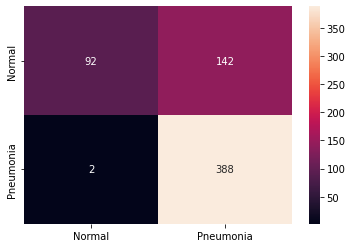

In [24]:
#get the confusion matrix
cm = confusion_matrix(labels,pred)
sns.heatmap(cm,annot=True,fmt='g',xticklabels=['Normal','Pneumonia'],yticklabels=['Normal','Pneumonia'])